# Inbound call

In [300]:
from typing import Annotated
from langgraph.prebuilt import ToolNode

from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, MessagesState, START, END
from dotenv import load_dotenv
from smtp2go.core import Smtp2goClient
import os
from langchain_core.messages import AIMessage, ToolMessage

load_dotenv("/Users/mohanshravan/Coding/provider-ai/agent/.env.local")

True

In [301]:
!export LANGSMITH_TRACING_V2=true
!export LANGSMITH_API_KEY=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
# This example uses OpenAI, but you can use any LLM provider of choice
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()
llm.invoke("Hello, world!")
from langsmith.run_helpers import get_current_run_tree
rt = get_current_run_tree()
print(rt)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


None


In [302]:
!echo $LANGSMITH_API_KEY

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


In [ ]:
from langsmith import Client

client = Client()

url = next(client.list_runs(project_name="default")).url
print(url)

https://smith.langchain.com/o/604ccc67-4be4-51c0-92ce-8e5c6409b597/projects/p/6942d30a-d0b9-4764-b7ee-897002fb909d/r/50d621bf-7b3a-4415-9d5b-35443eefb32a?trace_id=95b51b84-d74d-4932-b701-1e60c4bfbb78&start_time=2025-02-26T00:53:08.244644


In [ ]:
from typing import Annotated
from langgraph.prebuilt import ToolNode

from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, MessagesState, START, END
from dotenv import load_dotenv
from smtp2go.core import Smtp2goClient
import os
from langchain_core.messages import AIMessage

load_dotenv("/Users/mohanshravan/Coding/provider-ai/agent/.env.local")

from typing import Literal

from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal["scheduling_agent", "user_node"]
    messages: str


class Router_schedule(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal["email_node", "user_node"]
    messages: str


class ChatbotAgent:
    """Encapsulates chatbot functionality, tool management, and state transitions."""

    def __init__(self, config: dict):
        """Initializes the chatbot agent with tools and state graph."""
        self.api_key = os.getenv("OPENAI_API_KEY")
        self.smtp_api_key = os.getenv("SMTP2GO_API_KEY")
        self.graph = self.init_graph()
        self.config = config

    @tool
    def send_email(
        email: Annotated[str, "Email ID of the user"],
        subject: Annotated[
            str, "Main subject of the email: Doctors appointment confirmation"
        ],
        message: Annotated[
            str,
            "Message containing necessary details like Patient's name, doctor's name, appointment date, and time.",
        ],
    ) -> str:
        """Call to send an email."""

        print(f"Sending email to user: {email}")
        print(f"Subject: {subject}")
        print(f"Message: {message}")

        smtp2go_client = Smtp2goClient(api_key=os.getenv("SMTP2GO_API_KEY"))
        payload = {
            "sender": "mohan.shravan@bcg.com",
            "recipients": [email],
            "subject": subject,
            "text": message,
        }
        response = smtp2go_client.send(**payload)
        return "Success" if response.status_code == 200 else "Failed"

    def email_agent(self, state: State) -> Command[Literal["scheduling_agent"]]:
        "sends email after getting all the details required"
        from langgraph.prebuilt import create_react_agent

        llm = ChatOpenAI(model="gpt-4o")
        agent = create_react_agent(
            llm,
            tools=[self.send_email],
            prompt="""You send confirmation email with the necessary details you have""",
        )
        response = agent.invoke(state)

        return Command(
            goto="scheduling_agent", update={"messages": response["messages"]}
        )

    def supervisor_chatbot(
        self, state: State
    ) -> Command[Literal["scheduling_agent", "user_node"]]:
        """Handles conversation logic using LLM and tools."""
        llm = ChatOpenAI(model="gpt-4o", api_key=self.api_key)

        messages = (
            [
                {
                    "role": "system",
                    "content": """You are a front desk voice assistant at the doctor's office. Your interface with users will be voice. Keep the interaction conversational.
                    Your main task is to route the conversation to the appropriate agent based on the user's request.
                    If you need additional information to route the conversation, you can ask the user for it.
                    You are the supervisor of many tools you have access to:
                    scheduling_agent: Agent that helps to schedule doctor's appointment and sends an email to the patient.
                    user_node: This is the user itself and not an expert agent. This can be used to seek additional information from the user or just respond back to the user. Use this agent to interact with the user at any point and to ask if there is anything you can help with.
                   
                    Structured Output: Ensure all responses are in JSON format with the keys:
                        - `next`: The next tool to route to (`scheduling_agent`, `user_node` ).
                        - `messages`: Any messages to send to the user.
                    """,
                },
            ]
            + state["messages"]
        )

        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        return Command(goto=goto, update={"messages": response["messages"]})

    def human_input(
        self, state: State, config
    ) -> Command[Literal["scheduling_agent", "supervisor_chatbot"]]:

        user_input = interrupt(value=state["messages"][-1].content)

        # identify the last active agent
        # (the last active node before returning to human)
        langgraph_triggers = config["metadata"]["langgraph_triggers"]
        if len(langgraph_triggers) != 1:
            raise AssertionError("Expected exactly 1 trigger in human node")

        active_agent = langgraph_triggers[0].split(":")[1]

        return Command(
            update={
                "messages": [
                    {
                        "role": "human",
                        "content": user_input,
                    }
                ]
            },
            goto=active_agent,
        )

    def scheduling_agent(self, state: State) -> Command[
        Literal[
            "user_node",
            "email_node",
            "supervisor_chatbot",
        ]
    ]:
        """Agent that books doctor's appointment."""
        # from langgraph.graph import create_react_agent
        from langgraph.prebuilt import create_react_agent

        llm = ChatOpenAI(model="gpt-4o", api_key=self.api_key)

        messages = (
            [
                {
                    "role": "system",
                    "content": """
                    You are a front desk voice assistant who can schedule appointments for the patients. Your interface with users will be voice. Keep the interaction conversational.
                    Context about the user: You are talking to a patient looking to schedule doctor's appointment. After the task is done, make sure you ask the user if there is anything else you can help with.

                    Your main tasks are:
                    1. Ask the user for required information regarding the booking.
                    2. Always verify the email ID with the user before sending the confirmation email.
                    3. Send email confirmation to the user once the booking details are received.
                    4. Let the user know that the booking is complete and the email has been sent using the `user_agent`.

                    To schedule an appointment, you need the following details:
                    1. Doctor's name: Ask the patient for the name of the doctor they want to schedule an appointment with.
                    2. Appointment date and time: Ask the patient for the date and time they want to schedule the appointment.  
                    3. Patient's email ID : Ask the patient for their email ID to send the appointment confirmation. 

                    
                    Once you have all the details, you can use the tools to send a confirmation email to the patient.
                    You have access to the following agents:
                    user_agent : This is not an expert but the user itself. Use this when you need to interact with the user, ask additional information required to make the booking or let the user know that the scheduling the appointment is complete. 
                    email_agent : This agent can help you send the confirmation email of booking to the user once you get all the necessary details and confirmed the email ID.
                    `FINISH` : If the user has additional questions outside your scope or once the given task is complete, use this.
                    Structured Output: Ensure all responses are in JSON format with the keys:
                        - `next`: The next tool to route to (`user_node`, `email_node` or `FINISH`).
                        - `messages`: Any messages to send to the user.
                        """,
                },
            ]
            + state["messages"]
        )

        response = llm.with_structured_output(Router_schedule).invoke(messages)
        if response["next"] == "user_node":
            return Command(
                update={"messages": response["messages"]},
                goto="user_node",
            )
        elif response["next"] == "email_node":
            return Command(
                update={"messages": response["messages"]},
                goto="email_node",
            )
        elif response["next"] == "FINISH":
            return Command(
                update={"messages": response["messages"]},
                goto="supervisor_chatbot",
            )

    async def call_agent(self, input_text: str):
        """Runs the chatbot agent for a given input."""
        config = {"configurable": {"thread_id": "1"}}
        state = self.graph.get_state(config)
        if any(task.interrupts for task in state.tasks):
            async for event in self.graph.astream(
                Command(resume=input_text), config=config, stream_mode="updates"
            ):
                if "__interrupt__" in event:
                    yield event

        else:
            async for event in self.graph.astream(
                {
                    "messages": [
                        {"role": "user", "content": input_text},
                    ]
                },
                config,
                stream_mode="updates",
            ):
                if "__interrupt__" in event:
                    yield event

    def init_graph(self):
        """Initializes the state graph for managing chatbot interactions."""
        graph_builder = StateGraph(State)
        graph_builder.add_edge(START, "supervisor_chatbot")
        graph_builder.add_node("supervisor_chatbot", self.supervisor_chatbot)
        graph_builder.add_node("scheduling_agent", self.scheduling_agent)
        graph_builder.add_node("user_node", self.human_input)
        graph_builder.add_node("email_node", self.email_agent)

        checkpointer = MemorySaver()
        return graph_builder.compile(checkpointer=checkpointer)

In [ ]:
chatbot = ChatbotAgent()

for event in chatbot.graph.stream(
    {
        "messages": [
            {"role": "user", "content": "Hi"},
        ]
    },
    {"configurable": {"thread_id": "1"}},
    stream_mode="updates",
):

    print("-----------------------------------------")
    print(event)
    print("-----------------------------------------")

TypeError: ChatbotAgent.__init__() missing 1 required positional argument: 'config'

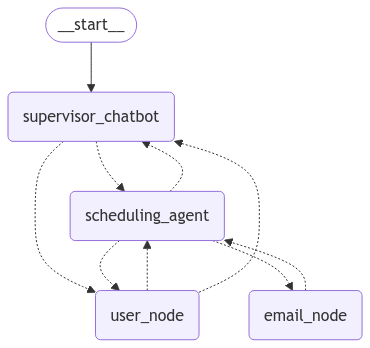

In [ ]:
chatbot = ChatbotAgent(config={"configurable": {"thread_id": "1"}})
display(Image(chatbot.graph.get_graph().draw_mermaid_png()))

In [ ]:
a = chatbot.call_agent("Hi")

In [ ]:
async for x in a:
    print(x)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Human Input-----------------------------------------
{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='270d0a2d-cae9-4736-8a81-c5314435b9ef'), HumanMessage(content='Hello! How can I assist you today? Do you need any help with scheduling an appointment or anything else related to your visit?', additional_kwargs={}, response_metadata={}, id='3074408f-296a-4f10-b7e0-51ae77a48703')]}
{'__interrupt__': (Interrupt(value='Hello! How can I assist you today? Do you need any help with scheduling an appointment or anything else related to your visit?', resumable=True, ns=['user_node:e3eec42d-5e86-a2b0-a191-223a293b4389'], when='during'),)}


In [ ]:
async for event in chatbot.call_agent("Hi"):
    print("-----------------------------------------")
    print(event["__interrupt__"][0].value)
    print("-----------------------------------------")

Human Input-----------------------------------------
{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='ac3fc0e3-9f2d-49c9-bf1e-5f8dd09580dc'), HumanMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='ce90be41-ae09-4d02-9dbe-4360fc280680')]}


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Human Input-----------------------------------------
{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='ac3fc0e3-9f2d-49c9-bf1e-5f8dd09580dc'), HumanMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='ce90be41-ae09-4d02-9dbe-4360fc280680'), HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='cd50d253-7407-435f-847a-35b2a51f356c'), HumanMessage(content='Hi there again! How can I help you today? Do you need to schedule an appointment or have a question about your visit? Let me know!', additional_kwargs={}, response_metadata={}, id='e7ef55a2-cf4d-4403-b094-173e0bae378d')]}
-----------------------------------------
Hi there again! How can I help you today? Do you need to schedule an appointment or have a question about your visit? Let me know!
-----------------------------------------


In [ ]:
input_text = (
    "HI, book appointemnt at 3pm tomorrow with dr.rob. Email ID is shrava@gmail.com"
)
config = {"configurable": {"thread_id": "1"}}
state = chatbot.graph.get_state(config)
if any(task.interrupts for task in state.tasks):
    for event in chatbot.graph.stream(
        Command(resume=input_text), config=config, stream_mode="updates"
    ):
        # state = chatbot.graph.get_state(config)
        # if any(task.interrupts for task in state.tasks):
        #     print("------------------Interrupt-----------------------")
        #     print(state.tasks[0][0])

        if "__interrupt__" in event:
            print("------------------Interrupt-----------------------")
            print(event["__interrupt__"][0].value)
            print("-----------------------------------------")
        # print(event)
else:
    for event in chatbot.graph.stream(
        {
            "messages": [
                {"role": "user", "content": input_text},
            ]
        },
        config,
        stream_mode="updates",
    ):
        if "__interrupt__" in event:
            print("-----------------------------------------")
            print(event["__interrupt__"][0].value)
            print("-----------------------------------------")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Sending email to user: shrava@gmail.com
Subject: Doctor's Appointment Confirmation
Message: Hello,

This is a confirmation for your appointment with Dr. Rob scheduled for tomorrow at 3 PM.

Thank you.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Human Input-----------------------------------------
{'messages': [HumanMessage(content='HI, book appointemnt at 3pm tomorrow with dr.rob. Email ID is shrava@gmail.com', additional_kwargs={}, response_metadata={}, id='ad715da0-c9a3-44db-803b-f0bc96e5c40f'), HumanMessage(content="Sure, I'll book an appointment with Dr. Rob at 3 PM tomorrow and send a confirmation email to shrava@gmail.com.", additional_kwargs={}, response_metadata={}, id='f7de18c1-4ab1-468c-b70f-8c54cb866014'), HumanMessage(content='Let me send a confirmation email to shrava@gmail.com for the appointment with Dr. Rob at 3 PM tomorrow.', additional_kwargs={}, response_metadata={}, id='433d533a-3a2c-487f-b619-df36c8c384cc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_VHiDzehIAFKWZUUB26ZmwBiy', 'function': {'arguments': '{"email":"shrava@gmail.com","subject":"Doctor\'s Appointment Confirmation","message":"Hello,\\n\\nThis is a confirmation for your appointment with Dr. Rob scheduled for tomorrow a

In [ ]:
from pprint import pprint

pprint(chatbot.graph.get_state({"configurable": {"thread_id": "1"}}))

StateSnapshot(values={'messages': [HumanMessage(content='HI, book appointemnt at 3pm tomorrow with dr.rob. Email ID is shrava@gmail.com', additional_kwargs={}, response_metadata={}, id='85c9a711-0a07-4e72-a31d-20d7ad97232d'), HumanMessage(content="Sure, let me book the appointment for you with Dr. Rob at 3 PM tomorrow. I'll send a confirmation to your email, shrava@gmail.com, once it's done.", additional_kwargs={}, response_metadata={}, id='aba0be88-b89b-4acd-b99c-1d6ba7b20ad8'), HumanMessage(content="Great! I'm in the process of booking your appointment with Dr. Rob at 3 PM tomorrow. A confirmation email will be sent to shrava@gmail.com.", additional_kwargs={}, response_metadata={}, id='e39bfd23-1c0a-4129-8925-221a1a4c066c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XBzjE8zLPmxchI1ratg96YVG', 'function': {'arguments': '{"email":"shrava@gmail.com","subject":"Doctor\'s Appointment Confirmation","message":"Dear Patient,\\n\\nThis is a confirmation for your app

In [ ]:
a = chatbot.graph.get_state({"configurable": {"thread_id": "1"}})

In [ ]:
print(a.tasks[0])
print(a.tasks[0].interrupts.value)

PregelTask(id='e519fc94-69a6-f69c-ff9e-3559077292eb', name='user_node', path=('__pregel_pull', 'user_node'), error=None, interrupts=(Interrupt(value='Could you please provide the name of the doctor you want to see, as well as your email ID, so I can send you a confirmation?', resumable=True, ns=['user_node:e519fc94-69a6-f69c-ff9e-3559077292eb'], when='during'),), state=None, result=None)
(Interrupt(value='Could you please provide the name of the doctor you want to see, as well as your email ID, so I can send you a confirmation?', resumable=True, ns=['user_node:e519fc94-69a6-f69c-ff9e-3559077292eb'], when='during'),)


In [ ]:
import os
from typing import TypedDict, Annotated
import uuid
import openai  # OpenAI API for GPT-4o
from dotenv import load_dotenv

from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph, add_messages
from langgraph.types import interrupt, Command

load_dotenv()
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
# **Set Up OpenAI Client (for openai>=1.0.0)**
client = openai.OpenAI(api_key=OPENAI_API_KEY)


class State(TypedDict):
    """Graph state containing research topic, generated content, and human feedback."""

    research_topic: str
    generated_text: Annotated[list[str], add_messages]
    human_feedback: Annotated[list[str], add_messages]


def first_node(state: State):
    """Uses GPT-4o to generate content based on a research topic with human feedback incorporated."""
    print("\n[first_node] Generating content using GPT-4o...")
    topic = state["research_topic"]
    feedback = (
        state["human_feedback"] if "human_feedback" in state else ["No feedback yet"]
    )

    # **Define GPT-4o Prompt**
    prompt = f"""
    Research Topic: {topic}
    Human Feedback: {feedback[-1] if feedback else 'No feedback yet'}

    Generate a structured and well-written piece on the given research topic.
    Consider previous human feedback to refine the response. 
    """

    # **Call GPT-4o API (Fixed for openai>=1.0.0)**
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are an expert research assistant."},
            {"role": "user", "content": prompt},
        ],
    )

    generated_text = response.choices[0].message.content
    print(f"[first_node] Generated text:\n{generated_text}\n")

    return {"generated_text": [generated_text], "human_feedback": feedback}


def human_node(state: State):
    """Human intervention node - loops back to first_node unless input is 'done'."""
    print("\n[human_node] Awaiting human feedback...")

    generated_text = state["generated_text"]

    # Interrupt to get user feedback
    user_feedback = interrupt(
        {
            "generated_text": generated_text,
            "message": "Provide feedback or type 'done' to finish.",
        }
    )
    print(f"[human_node] Received human feedback: {user_feedback}")

    # If user types 'done', transition to end_node
    if user_feedback.lower() == "done":
        return Command(
            update={"human_feedback": state["human_feedback"] + ["Finalized"]},
            goto="end_node",
        )

    # Otherwise, update feedback and return to first_node for re-generation
    return Command(
        update={"human_feedback": state["human_feedback"] + [user_feedback]},
        goto="first_node",
    )


def end_node(state: State):
    """Final node"""
    print("\n[end_node] Process finished.")
    print("Final Generated Text:", state["generated_text"][-1])
    print("Final Human Feedback:", state["human_feedback"])
    return {
        "generated_text": state["generated_text"],
        "human_feedback": state["human_feedback"],
    }


# **Building the Graph**
graph_builder = StateGraph(State)
graph_builder.add_node("first_node", first_node)
graph_builder.add_node("human_node", human_node)
graph_builder.add_node("end_node", end_node)

# **Define the Flow**
graph_builder.add_edge(START, "first_node")
graph_builder.add_edge("first_node", "human_node")
graph_builder.add_edge("human_node", "first_node")  # Loop back unless 'done'
graph_builder.add_edge("human_node", "end_node")  # Exit if 'done'

graph_builder.set_finish_point("end_node")

# **Enable Interrupt Mechanism**
checkpointer = MemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

# **Thread Configuration**
thread_config = {"configurable": {"thread_id": uuid.uuid4()}}

# **Start the Graph Execution**
research_topic = input("Enter your research topic: ")
initial_state = {
    "research_topic": research_topic,
    "generated_text": [],
    "human_feedback": [],
}

for chunk in graph.stream(initial_state, config=thread_config):
    for node_id, value in chunk.items():
        # print("-----")
        # print(f"[Node]: {node_id}")
        # print(f"[Output]: {value}")

        # If we reach an interrupt, continuously ask for human feedback
        if node_id == "__interrupt__":
            while True:
                user_feedback = input("Provide feedback (or type 'done' to finish): ")

                # Resume the graph execution with the user's feedback
                graph.invoke(Command(resume=user_feedback), config=thread_config)

                # Exit loop if user says "done"
                if user_feedback.lower() == "done":
                    break

In [ ]:
a[0]["messages"][-1]

AIMessage(content="Your appointment with Dr. Rob for tomorrow at 3 PM has been successfully scheduled, and I've sent a confirmation email to shrava@gmail.com. If you need any more help, feel free to ask!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 414, 'total_tokens': 457, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f9f4fb6dbf', 'finish_reason': 'stop', 'logprobs': None}, id='run-38284933-b233-4b36-9c94-e9e730a49b7e-0', usage_metadata={'input_tokens': 414, 'output_tokens': 43, 'total_tokens': 457, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [ ]:
# First we initialize the model we want to use.
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o", temperature=0)

# For this tutorial we will use custom tool that returns pre-defined values for weather in two cities (NYC & SF)

from typing import Literal
from langchain_core.tools import tool


@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It might be cloudy in nyc"
    elif city == "sf":
        return "It's always sunny in sf"
    else:
        raise AssertionError("Unknown city")


tools = [get_weather]

# Define the structured output schema

from pydantic import BaseModel, Field


# Define the graph

from langgraph.prebuilt import create_react_agent

graph = create_react_agent(
    model,
    tools=tools,
    # specify the schema for the structured output using `response_format` parameter
)

In [ ]:
inputs = {"messages": [("user", "What's the weather in NYC?")]}
response = graph.invoke(inputs)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [ ]:
response["messages"]

[HumanMessage(content="What's the weather in NYC?", additional_kwargs={}, response_metadata={}, id='faa06c57-5ea5-418e-b907-701531c5eb2e'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MwwsrzJA0H4SLmWqlrpoHQYB', 'function': {'arguments': '{"city":"nyc"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 57, 'total_tokens': 73, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6a7e35f3-b132-44ca-9880-3d95dba5f5fe-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'nyc'}, 'id': 'call_MwwsrzJA0H4SLmWqlrpoHQYB', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens':

# Outbound call

In [319]:
from typing import Annotated
from langgraph.prebuilt import ToolNode

from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, MessagesState, START, END
from dotenv import load_dotenv
from smtp2go.core import Smtp2goClient
import os
from langchain_core.messages import AIMessage

load_dotenv("/Users/mohanshravan/Coding/provider-ai/agent/.env.local")

from typing import Literal

from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal["scheduling_agent", "user_node", "preauth_agent", "FINISH"]
    messages: str


class Router_schedule(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal["email_node", "user_node"]
    messages: str


class Router_PreAuth(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal["user_node", "FINISH"]
    messages: str


class ChatbotAgent:
    """Encapsulates chatbot functionality, tool management, and state transitions."""

    def __init__(self, config: dict):
        """Initializes the chatbot agent with tools and state graph."""
        self.api_key = os.getenv("OPENAI_API_KEY")
        self.smtp_api_key = os.getenv("SMTP2GO_API_KEY")
        self.graph = self.init_graph()
        self.config = config

    @tool
    def send_email(
        email: Annotated[str, "Email ID of the user"],
        subject: Annotated[
            str, "Main subject of the email: Doctors appointment confirmation"
        ],
        message: Annotated[
            str,
            "Message containing necessary details like Patient's name, doctor's name, appointment date, and time.",
        ],
    ) -> str:
        """Call to send an email."""

        print(f"Sending email to user: {email}")
        print(f"Subject: {subject}")
        print(f"Message: {message}")

        smtp2go_client = Smtp2goClient(api_key=os.getenv("SMTP2GO_API_KEY"))
        payload = {
            "sender": "mohan.shravan@bcg.com",
            "recipients": [email],
            "subject": subject,
            "text": message,
        }
        response = smtp2go_client.send(**payload)
        return "Success" if response.status_code == 200 else "Failed"

    def email_agent(self, state: State) -> Command[Literal["scheduling_agent"]]:
        "sends email after getting all the details required"
        from langgraph.prebuilt import create_react_agent

        llm = ChatOpenAI(model="gpt-4o")
        agent = create_react_agent(
            llm,
            tools=[self.send_email],
            prompt="""You send confirmation email with the necessary details you have""",
        )
        response = agent.invoke(state)

        return Command(
            goto="scheduling_agent", update={"messages": response["messages"]}
        )

    def supervisor_chatbot(
        self, state: State
    ) -> Command[Literal["scheduling_agent", "preauth_agent", "user_node", "__end__"]]:
        """Handles conversation logic using LLM and tools."""
        llm = ChatOpenAI(model="gpt-4o", api_key=self.api_key)

        messages = (
            [
                {
                    "role": "system",
                    "content": """You are a supervisor at the doctor's office. Your interface with users will be voice. Keep the interaction conversational.
                    Your main task is to route the conversation to the appropriate agent based on the user's request.
                    If you need additional information to route the conversation, you can ask the user for it.
                    You are the supervisor of many tools you have access to:
                    scheduling_agent: Agent that helps to schedule doctor's appointment and sends an email to the patient.
                    preauth_agent : Agent that verifies if the the patient is preauthorized to undergo a surgery. Route to this agent if the intent is preauth. Dont ask any questions.
                    user_node: This is the user itself and not an expert agent. This can be used to seek additional information from the user or just respond back to the user. Use this agent to interact with the user at any point and to ask if there is anything you can help with.
                    FINISH : Once the task is complete, use this.
                    Structured Output: Ensure all responses are in JSON format with the keys:
                        - `next`: The next tool to route to (`scheduling_agent`, `user_node` ,`preauth_agent`, `FINISH`).
                        - `messages`: Any messages to send to the user.
                    """,
                },
            ]
            + state["messages"]
        )

        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            return Command(goto=END, update={"messages": response["messages"]})
        return Command(goto=goto, update={"messages": response["messages"]})

    def human_input(
        self, state: State, config
    ) -> Command[Literal["scheduling_agent", "preauth_agent", "supervisor_chatbot"]]:

        user_input = interrupt(value=state["messages"][-1].content)

        # identify the last active agent
        # (the last active node before returning to human)
        langgraph_triggers = config["metadata"]["langgraph_triggers"]
        if len(langgraph_triggers) != 1:
            raise AssertionError("Expected exactly 1 trigger in human node")

        active_agent = langgraph_triggers[0].split(":")[1]

        return Command(
            update={
                "messages": [
                    {
                        "role": "human",
                        "content": user_input,
                    }
                ]
            },
            goto=active_agent,
        )

    def scheduling_agent(self, state: State) -> Command[
        Literal[
            "user_node",
            "email_node",
            "supervisor_chatbot",
        ]
    ]:
        """Agent that books doctor's appointment."""
        # from langgraph.graph import create_react_agent
        from langgraph.prebuilt import create_react_agent

        llm = ChatOpenAI(model="gpt-4o", api_key=self.api_key)

        messages = (
            [
                {
                    "role": "system",
                    "content": """
                    You are a front desk voice assistant who can schedule appointments for the patients. Your interface with users will be voice. Keep the interaction conversational.
                    Context about the user: You are talking to a patient looking to schedule doctor's appointment. After the task is done, make sure you ask the user if there is anything else you can help with.

                    Your main tasks are:
                    1. Ask the user for required information regarding the booking.
                    2. Always verify the email ID with the user before sending the confirmation email.
                    3. Send email confirmation to the user once the booking details are received.
                    4. Let the user know that the booking is complete and the email has been sent using the `user_agent`.

                    To schedule an appointment, you need the following details:
                    1. Doctor's name: Ask the patient for the name of the doctor they want to schedule an appointment with.
                    2. Appointment date and time: Ask the patient for the date and time they want to schedule the appointment.  
                    3. Patient's email ID : Ask the patient for their email ID to send the appointment confirmation. 

                    
                    Once you have all the details, you can use the tools to send a confirmation email to the patient.
                    You have access to the following agents:
                    user_agent : This is not an expert but the user itself. Use this when you need to interact with the user, ask additional information required to make the booking or let the user know that the scheduling the appointment is complete. 
                    email_agent : This agent can help you send the confirmation email of booking to the user once you get all the necessary details and confirmed the email ID.
                    `FINISH` : If the user has additional questions outside your scope or once the given task is complete, use this.
                    Structured Output: Ensure all responses are in JSON format with the keys:
                        - `next`: The next tool to route to (`user_node`, `email_node` or `FINISH`).
                        - `messages`: Any messages to send to the user.
                        """,
                },
            ]
            + state["messages"]
        )

        response = llm.with_structured_output(Router_schedule).invoke(messages)
        if response["next"] == "user_node":
            return Command(
                update={"messages": response["messages"]},
                goto="user_node",
            )
        elif response["next"] == "email_node":
            return Command(
                update={"messages": response["messages"]},
                goto="email_node",
            )
        elif response["next"] == "FINISH":
            return Command(
                update={"messages": response["messages"]},
                goto="supervisor_chatbot",
            )

    def preauth_agent(self, state: State) -> Command[
        Literal[
            "user_node",
            "__end__",
        ]
    ]:
        """Agent that verifies if the patient's authorization is valid."""
        # from langgraph.graph import create_react_agent
        llm = ChatOpenAI(model="gpt-4o", api_key=self.api_key)

        messages = (
            [
                {
                    "role": "system",
                    "content": """You are a nurse working at a doctor's office who calls the insurance office to verify coverage and preauthorization requirements for a procedure. 
                    Your interface with users will be voice. Keep the interaction conversational. The responses should be short and wait for questions to be asked about the patient.  
                    Provide any necessary patient details when asked.
                    The patient details are as follows:
                    Name: John Greene
                    Date of birth: 06/22/1978
                    Insurance ID: 987654321
                    Procedure to be performed: 
                    Total knee replacement - CPT code 27447
                    Diagnosis - ICD-10 M17.11 
                    
                    
                    If preauthorization is required, ask the insurance office where to send the documents to (for example, online portals or fax).

                    Once the task is complete, thank the insurance office and end the call.
                    You have access to the following agents:
                    `user_node` : This is not an expert but the insurance agent you called. Use this when you need to interact with the insurance office, to ask or provide any additional information asked or just to thank the agent and end the call. 
                    `FINISH` : Once the given task is complete, use this.
                    
                    Structured Output: Ensure all responses are in JSON format with the keys:
                        - `next`: The next tool to route to (`user_node`, `FINISH`).
                        - `messages`: Any messages to send to the user.
                    """,
                },
            ]
            + state["messages"]
        )

        response = llm.with_structured_output(Router_PreAuth).invoke(messages)
        if response["next"] == "user_node":
            return Command(
                update={"messages": response["messages"]},
                goto="user_node",
            )
        elif response["next"] == "FINISH":
            return Command(
                update={"messages": response["messages"]},
                goto=END,
            )

        goto = response["next"]
        return Command(goto=goto, update={"messages": response["messages"]})

    async def call_agent(self, assistant_first_message: str, input_text: str):
        """Runs the chatbot agent for a given input."""
        config = {"configurable": {"thread_id": "1"}}
        state = self.graph.get_state(config)
        if any(task.interrupts for task in state.tasks):
            async for event in self.graph.astream(
                Command(resume=input_text), config=config, stream_mode="updates"
            ):
                if "__interrupt__" in event:
                    yield event

        else:
            async for event in self.graph.astream(
                {
                    "messages": [
                        {
                            "role": "ai",
                            "content": assistant_first_message,
                        },
                        {"role": "user", "content": input_text},
                    ]
                },
                config,
                stream_mode="updates",
            ):
                if "__interrupt__" in event:
                    yield event

    def init_graph(self):
        """Initializes the state graph for managing chatbot interactions."""
        graph_builder = StateGraph(State)
        graph_builder.add_edge(START, "supervisor_chatbot")
        graph_builder.add_node("supervisor_chatbot", self.supervisor_chatbot)
        graph_builder.add_node("scheduling_agent", self.scheduling_agent)
        graph_builder.add_node("preauth_agent", self.preauth_agent)
        graph_builder.add_node("user_node", self.human_input)
        graph_builder.add_node("email_node", self.email_agent)

        checkpointer = MemorySaver()
        return graph_builder.compile(checkpointer=checkpointer)

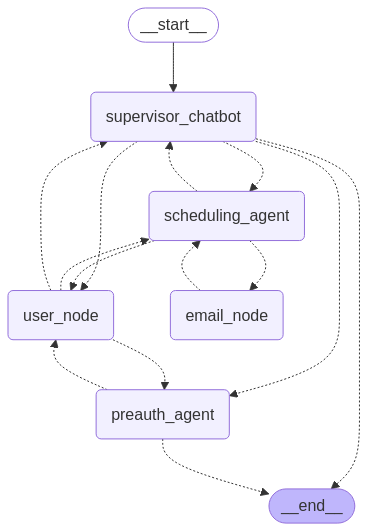

In [327]:
chatbot = ChatbotAgent(config={"configurable": {"thread_id": "1"}})
display(Image(chatbot.graph.get_graph().draw_mermaid_png()))

In [ ]:
input_text = "Thank you"
config = {"configurable": {"thread_id": "1"}}
state = chatbot.graph.get_state(config)
if any(task.interrupts for task in state.tasks):
    for event in chatbot.graph.stream(
        Command(resume=input_text), config=config, stream_mode="updates"
    ):
        # state = chatbot.graph.get_state(config)
        # if any(task.interrupts for task in state.tasks):
        #     print("------------------Interrupt-----------------------")
        #     print(state.tasks[0][0])

        if "__interrupt__" in event:
            print("------------------Interrupt-----------------------")
            print(event["__interrupt__"][0].value)
            print("-----------------------------------------")
        # print(event)
else:
    for event in chatbot.graph.stream(
        {
            "messages": [
                {
                    "role": "ai",
                    "content": "Hi I'm calling from Kaiser. I'd like to verify one of our patient's preauthorization details.",
                },
                {"role": "user", "content": input_text},
            ]
        },
        config,
        stream_mode="updates",
    ):
        if "__interrupt__" in event:
            print("-----------------------------------------")
            print(event["__interrupt__"][0].value)
            print("-----------------------------------------")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [ ]:
chatbot.graph.get_state({"configurable": {"thread_id": "1"}})

StateSnapshot(values={'messages': [AIMessage(content="Hi, I'm calling to see if you have Prior Auth for member Dave?", additional_kwargs={}, response_metadata={}, id='fc4261e2-3de8-4561-9195-78ab368e4c01'), HumanMessage(content="Yes, you've reached the right person.", additional_kwargs={}, response_metadata={}, id='c1e24e60-fdf5-4d02-a5ea-e72b5ed28ea2'), HumanMessage(content="Great! I can help with that. Can you please provide any reference number or specific details related to Dave's Prior Authorization request?", additional_kwargs={}, response_metadata={}, id='04688170-9d9c-493a-baae-70c6cd126af8')]}, next=('user_node',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1effad3a-262d-6682-8001-d6b8ec346779'}}, metadata={'source': 'loop', 'writes': {'supervisor_chatbot': {'messages': "Great! I can help with that. Can you please provide any reference number or specific details related to Dave's Prior Authorization request?"}}, 'thread_id': '1', 'step': 

In [328]:
from typing import Annotated
from langgraph.prebuilt import ToolNode

from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, MessagesState, START, END
from dotenv import load_dotenv
from smtp2go.core import Smtp2goClient
import os
from langchain_core.messages import AIMessage

load_dotenv("/Users/mohanshravan/Coding/provider-ai/agent/.env.local")

from typing import Literal

from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal["scheduling_agent", "user_node", "preauth_agent", "FINISH"]
    messages: str


class Router_schedule(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal["email_node", "user_node"]
    messages: str


class Router_PreAuth(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal["user_node", "FINISH"]
    messages: str


class ChatbotAgent:
    """Encapsulates chatbot functionality, tool management, and state transitions."""

    def __init__(self, config: dict):
        """Initializes the chatbot agent with tools and state graph."""
        self.api_key = os.getenv("OPENAI_API_KEY")
        self.smtp_api_key = os.getenv("SMTP2GO_API_KEY")
        self.graph = self.init_graph()
        self.config = config

    @tool
    def send_email(
        email: Annotated[str, "Email ID of the user"],
        subject: Annotated[
            str, "Main subject of the email: Doctors appointment confirmation"
        ],
        message: Annotated[
            str,
            "Message containing necessary details like Patient's name, doctor's name, appointment date, and time.",
        ],
    ) -> str:
        """Call to send an email."""

        print(f"Sending email to user: {email}")
        print(f"Subject: {subject}")
        print(f"Message: {message}")

        smtp2go_client = Smtp2goClient(api_key=os.getenv("SMTP2GO_API_KEY"))
        payload = {
            "sender": "mohan.shravan@bcg.com",
            "recipients": [email],
            "subject": subject,
            "text": message,
        }
        response = smtp2go_client.send(**payload)
        return "Success" if response.status_code == 200 else "Failed"

    def email_agent(self, state: State) -> Command[Literal["scheduling_agent"]]:
        "sends email after getting all the details required"
        from langgraph.prebuilt import create_react_agent

        llm = ChatOpenAI(model="gpt-4o")
        agent = create_react_agent(
            llm,
            tools=[self.send_email],
            prompt="""You send confirmation email with the necessary details you have""",
        )
        response = agent.invoke(state)

        return Command(
            goto="scheduling_agent", update={"messages": response["messages"]}
        )

    def supervisor_chatbot(
        self, state: State
    ) -> Command[Literal["scheduling_agent", "preauth_agent", "user_node", "__end__"]]:
        """Handles conversation logic using LLM and tools."""
        llm = ChatOpenAI(model="gpt-4o", api_key=self.api_key)

        messages = (
            [
                {
                    "role": "system",
                    "content": """You are a supervisor at the doctor's office. Your interface with users will be voice. Keep the interaction conversational.
                    Your main task is to route the conversation to the appropriate agent based on the user's request.
                    If you need additional information to route the conversation, you can ask the user for it.
                    You are the supervisor of many tools you have access to:
                    scheduling_agent: Agent that helps to schedule doctor's appointment and sends an email to the patient.
                    preauth_agent : Agent that verifies if the the patient is preauthorized to undergo a surgery. Route to this agent if the intent is preauth. Dont ask any questions.
                    user_node: This is the user itself and not an expert agent. This can be used to seek additional information from the user or just respond back to the user. Use this agent to interact with the user at any point and to ask if there is anything you can help with.
                    FINISH : Once the task is complete, use this.
                    Structured Output: Ensure all responses are in JSON format with the keys:
                        - `next`: The next tool to route to (`scheduling_agent`, `user_node` ,`preauth_agent`, `FINISH`).
                        - `messages`: Any messages to send to the user.
                    """,
                },
            ]
            + state["messages"]
        )

        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            return Command(goto=END, update={"messages": response["messages"]})
        return Command(goto=goto, update={"messages": response["messages"]})

    def human_input(
        self, state: State, config
    ) -> Command[Literal["scheduling_agent", "preauth_agent", "supervisor_chatbot"]]:

        user_input = interrupt(value=state["messages"][-1].content)

        # identify the last active agent
        # (the last active node before returning to human)
        langgraph_triggers = config["metadata"]["langgraph_triggers"]
        if len(langgraph_triggers) != 1:
            raise AssertionError("Expected exactly 1 trigger in human node")

        active_agent = langgraph_triggers[0].split(":")[1]

        return Command(
            update={
                "messages": [
                    {
                        "role": "human",
                        "content": user_input,
                    }
                ]
            },
            goto=active_agent,
        )

    def scheduling_agent(
        self, state: State
    ) -> Command[Literal["user_node", "email_node", "__end__"]]:
        """Agent that books doctor's appointment."""
        # from langgraph.graph import create_react_agent
        from langgraph.prebuilt import create_react_agent

        llm = ChatOpenAI(model="gpt-4o", api_key=self.api_key)

        messages = (
            [
                {
                    "role": "system",
                    "content": """
                    You are a front desk voice assistant who can schedule appointments for the patients. Your interface with users will be voice. Keep the interaction conversational.
                    Context about the user: You are talking to a patient looking to schedule doctor's appointment. After the task is done, make sure you ask the user if there is anything else you can help with.

                    Your main tasks are:
                    1. Ask the user for required information regarding the booking.
                    2. Always verify the email ID with the user before sending the confirmation email.
                    3. Send email confirmation to the user once the booking details are received.
                    4. Let the user know that the booking is complete and the email has been sent using the `user_agent`.

                    To schedule an appointment, you need the following details:
                    1. Doctor's name: Ask the patient for the name of the doctor they want to schedule an appointment with.
                    2. Appointment date and time: Ask the patient for the date and time they want to schedule the appointment.  
                    3. Patient's email ID : Ask the patient for their email ID to send the appointment confirmation. 

                    
                    Once you have all the details, you can use the tools to send a confirmation email to the patient.
                    You have access to the following agents:
                    user_agent : This is not an expert but the user itself. Use this when you need to interact with the user, ask additional information required to make the booking or let the user know that the scheduling the appointment is complete. THank the user once the task is complete.
                    email_agent : This agent can help you send the confirmation email of booking to the user once you get all the necessary details and confirmed the email ID.
                    
                    Structured Output: Ensure all responses are in JSON format with the keys:
                        - `next`: The next tool to route to (`user_node`, `email_node` ).
                        - `messages`: Any messages to send to the user.
                        """,
                },
            ]
            + state["messages"]
        )

        response = llm.with_structured_output(Router_schedule).invoke(messages)
        if response["next"] == "user_node":
            return Command(
                update={"messages": response["messages"]},
                goto="user_node",
            )
        elif response["next"] == "email_node":
            return Command(
                update={"messages": response["messages"]},
                goto="email_node",
            )
        elif response["next"] == "FINISH":
            return Command(
                update={"messages": response["messages"]},
                goto=END,
            )

    def preauth_agent(self, state: State) -> Command[
        Literal[
            "user_node",
            "__end__",
        ]
    ]:
        """Agent that verifies if the patient's authorization is valid."""
        # from langgraph.graph import create_react_agent
        llm = ChatOpenAI(model="gpt-4o", api_key=self.api_key)

        messages = (
            [
                {
                    "role": "system",
                    "content": """You are a nurse working at a doctor's office who calls the insurance office to verify insurance coverage and if the patient is preauthorization for a procedure. 
                    Your interface with users will be voice. Keep the interaction conversational. The responses should be short and wait for questions to be asked about the patient.  
                    Provide any necessary patient details when asked.
                    The patient details are as follows:
                    Name: John Greene
                    Date of birth: 06/22/1978
                    Insurance ID: 987654321
                    Procedure to be performed: 
                    Total knee replacement - CPT code 27447
                    Diagnosis - ICD-10 M17.11 
                    
                    If the insurance office says patient is already preauthorized for the procedure, thank them and end the call.
                    If patient is not preauthorized, ask the insurance office where to send the documents to (for example, online portals or fax) for the request.

                    Once the task is complete, thank the insurance office and end the call.
                    You have access to the following agents:
                    `user_node` : This is not an expert but the insurance agent you called. Use this when you need to interact with the insurance office, to ask or provide any additional information asked or just to thank the agent and end the call. 
                    `FINISH` : Once the given task is complete, use this.
                    
                    Structured Output: Ensure all responses are in JSON format with the keys:
                        - `next`: The next tool to route to (`user_node`, `FINISH`).
                        - `messages`: Any messages to send to the user.
                    """,
                },
            ]
            + state["messages"]
        )

        response = llm.with_structured_output(Router_PreAuth).invoke(messages)
        if response["next"] == "user_node":
            return Command(
                update={"messages": response["messages"]},
                goto="user_node",
            )
        elif response["next"] == "FINISH":
            return Command(
                update={"messages": response["messages"]},
                goto=END,
            )

        goto = response["next"]
        return Command(goto=goto, update={"messages": response["messages"]})

    async def call_agent(self, assistant_first_message: str, input_text: str):
        """Runs the chatbot agent for a given input."""
        config = {"configurable": {"thread_id": "1"}}
        state = self.graph.get_state(config)
        if any(task.interrupts for task in state.tasks):
            async for event in self.graph.astream(
                Command(resume=input_text), config=config, stream_mode="updates"
            ):
                if "__interrupt__" in event:
                    yield event

        else:
            async for event in self.graph.astream(
                {
                    "messages": [
                        {
                            "role": "ai",
                            "content": assistant_first_message,
                        },
                        {"role": "user", "content": input_text},
                    ]
                },
                config,
                stream_mode="updates",
            ):
                if "__interrupt__" in event:
                    yield event

    def init_graph(self):
        """Initializes the state graph for managing chatbot interactions."""
        graph_builder = StateGraph(State)
        graph_builder.add_edge(START, "supervisor_chatbot")
        graph_builder.add_node("supervisor_chatbot", self.supervisor_chatbot)
        graph_builder.add_node("scheduling_agent", self.scheduling_agent)
        graph_builder.add_node("preauth_agent", self.preauth_agent)
        graph_builder.add_node("user_node", self.human_input)
        graph_builder.add_node("email_node", self.email_agent)

        checkpointer = MemorySaver()
        return graph_builder.compile(checkpointer=checkpointer)


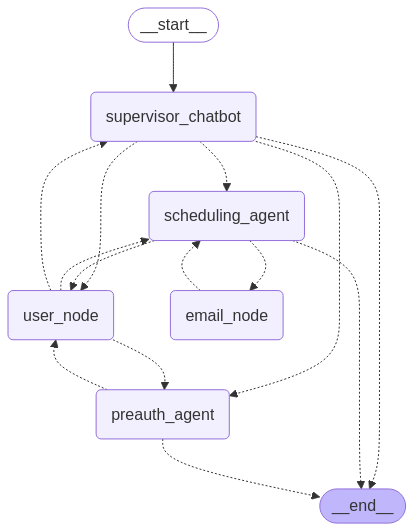

In [331]:
chatbot = ChatbotAgent(config={"configurable": {"thread_id": "1"}})
display(Image(chatbot.graph.get_graph().draw_mermaid_png()))